In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_predict, LeaveOneOut, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import skew, kurtosis
import tensorflow as tf
from sklearn.tree import DecisionTreeClassifier, plot_tree

## Part A: Classification Problem and Logistic Regression

In [3]:
credit = pd.read_csv("credit.csv", index_col=0)
credit.head()

,Default,WC/TA,RE/TA,EBIT/TA,ME/TL,S/TA
1,0,0.457619,0.224064,0.031838,1.288137,0.318193
2,0,0.121053,-0.114041,0.037298,0.457176,0.312122
3,0,-0.034844,-0.041509,0.017398,0.086529,0.186875
4,0,-0.007908,0.164338,0.045521,0.622297,0.106294
5,0,0.159241,0.429216,0.069642,5.060882,0.220953


In [4]:
y = credit["Default"]
X = credit.drop("Default", axis=1)

### a.

I use statsmodels for this part since it provides nice and neat model summary with significance levels and confidence intervals. Logit from statsmodels is equivalent of scikit-learn's logistic regression with newton-cg solver and no penalty.

In [5]:
logit_model = sm.Logit(y, sm.add_constant(X))
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.227475
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                Default   No. Observations:                  744
Model:                          Logit   Df Residuals:                      738
Method:                           MLE   Df Model:                            5
Date:                Tue, 25 Jun 2024   Pseudo R-squ.:                  0.2707
Time:                        20:47:04   Log-Likelihood:                -169.24
converged:                       True   LL-Null:                       -232.05
Covariance Type:            nonrobust   LLR p-value:                 2.031e-25
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0984      0.328     -3.345      0.001      -1.742      -0.455
WC/TA          0.6688      0.

Since 1's in y denote default, the variables whose signs are positive increase the default risk and vice versa. Therefore,
*   Higher levels of working capital can increase the default risk, but magnitude of its coefficient is the lowest (has less impact). Plus, it's not statistically significant.
*   Retained earnings, EBIT and market value of equity reduce the risk of default. By looking their coefficients' magnitudes, they're the most important factors. EBIT seems to be most important one, by far. RE/TA and ME/TL are statistically significant and EBIT/TA is significant at 0.10 level.
*   Just like working capital, sales can increase the default risk and it is statistically significant at 0.10 level.
*   Magnitudes can be misleading because these variables are not standardized.



In [6]:
# this is same as above
LogisticRegression(solver="newton-cg", penalty=None).fit(X, y).coef_

array([[ 0.66876174, -1.19867717, -6.97966748, -1.57360202,  1.07766426]])

### b.

In [7]:
print("McFadden's pseudo-R-squared is: ", round(result.prsquared,2))

McFadden's pseudo-R-squared is:  0.27


In logistic regression, we regress probabilities and convert these probabilities into binary values. So, we are actually doing an interval prediction rather than point estimation. Both 0.49 and 0.01 will get 0 as class prediction if the threshold is 0.50 (there is no difference in being wrong with 0.49 and 0.01). For that reason, we use accuracy and ROC for model evaluation and there is no true R-squared but pseudo-R-squared values in logistic regression unlike OLS.

### c.

In [8]:
y_pred_prob = result.predict(sm.add_constant(X))  # this is predicted probabilities
y_pred = [0 if p < 0.5 else 1 for p in y_pred_prob]  # and this is predicted classes

In [9]:
# this function could be handy for truth table
def my_truth_table(actual, predicted, title="Truth Table", decimals=2):
  cm = metrics.confusion_matrix(actual, predicted)
  truth_table = pd.DataFrame(cm, columns=[0,1], index=[0,1]).reindex([1,0])[[1,0]]
  accuracy = round(metrics.accuracy_score(actual, predicted), decimals)
  ax = sns.heatmap(truth_table, annot=True, fmt="g", cmap="YlGnBu", cbar=False,
                  linecolor="black", linewidths=0.5, clip_on=False, square=True)
  ax.xaxis.set_label_position("top")
  ax.xaxis.tick_top()
  ax.tick_params(left=False, top=False)
  plt.yticks(rotation=0)
  plt.title(title+f"\nAccuracy: {accuracy}", y=1.14)
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.tight_layout()

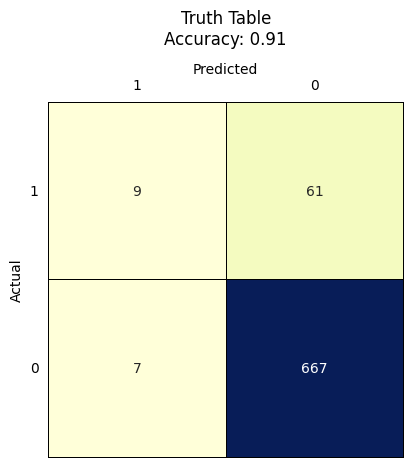

In [10]:
my_truth_table(y, y_pred)

### d.

The model's accuracy rate is almost 91% and the model suffers mostly from false negatives (type 2 error). It may be more problematic because when the actual label is 1 and the model predicts 0, this means that the model classifies the 61 companies that went bankrupt as survivors. If we want to consider in a conservative way we may use other metrics such as sensitivity.

### e.

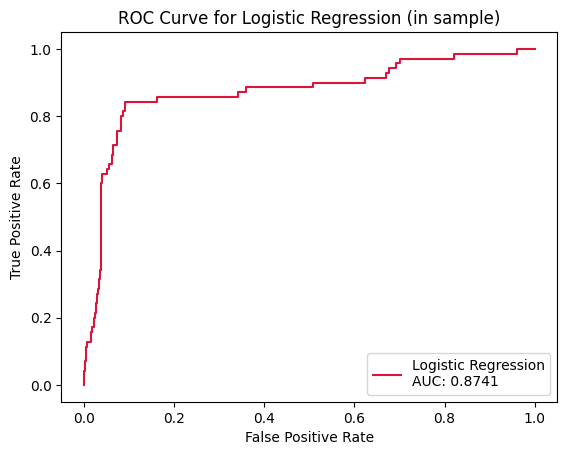

In [11]:
fpr, tpr, _ = metrics.roc_curve(y, y_pred_prob)
auc = metrics.roc_auc_score(y, y_pred_prob)
plt.plot(fpr, tpr, label=f"Logistic Regression\nAUC: {round(auc,4)}", color="crimson")
plt.legend(loc=4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Logistic Regression (in sample)")
plt.show()

### f.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =.1, shuffle=False)

In [13]:
logit_model2 = sm.Logit(y_train, sm.add_constant(X_train)).fit()
print(logit_model2.summary())

Optimization terminated successfully.
         Current function value: 0.133074
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                Default   No. Observations:                  669
Model:                          Logit   Df Residuals:                      663
Method:                           MLE   Df Model:                            5
Date:                Tue, 25 Jun 2024   Pseudo R-squ.:                  0.2542
Time:                        20:47:05   Log-Likelihood:                -89.027
converged:                       True   LL-Null:                       -119.38
Covariance Type:            nonrobust   LLR p-value:                 8.697e-12
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1706      0.469     -2.494      0.013      -2.091      -0.251
WC/TA          1.0836      0

In [14]:
y_pred_prob2 = logit_model2.predict(sm.add_constant(X_test))
y_pred2 = [0 if p < 0.5 else 1 for p in y_pred_prob2]

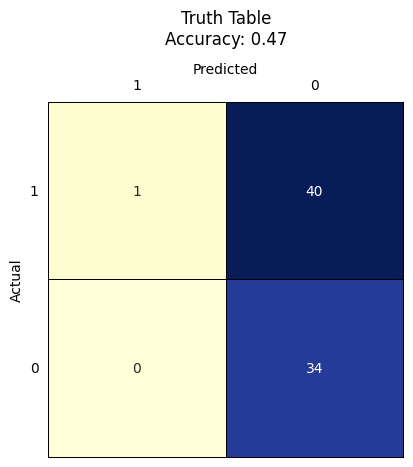

In [15]:
my_truth_table(y_test, y_pred2)

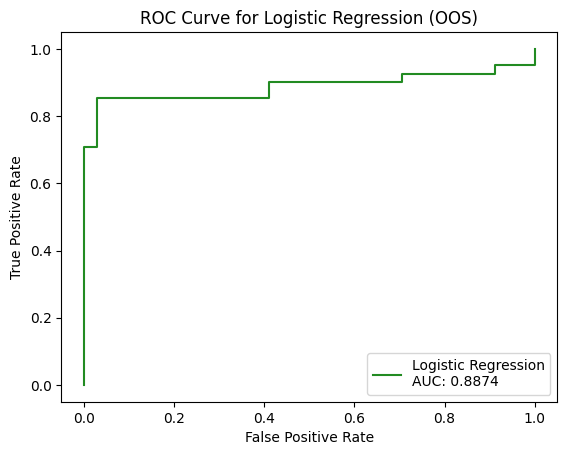

In [16]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_prob2)
auc = metrics.roc_auc_score(y_test, y_pred_prob2)
plt.plot(fpr, tpr,
         label=f"Logistic Regression\nAUC: {round(auc,4)}", color="forestgreen")
plt.legend(loc=4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Logistic Regression (OOS)")
plt.show()

### g.

After that part, I will go on with scikit learn's models rather than statsmodels since this makes cross validation much more easier.

In [17]:
log_reg = LogisticRegression(solver="newton-cg", penalty=None)
probs_loo = cross_val_predict(log_reg, X, y, cv=LeaveOneOut(), method="predict_proba")[:,1]
probs_10fold = cross_val_predict(log_reg, X, y, cv=KFold(10), method="predict_proba")[:,1]

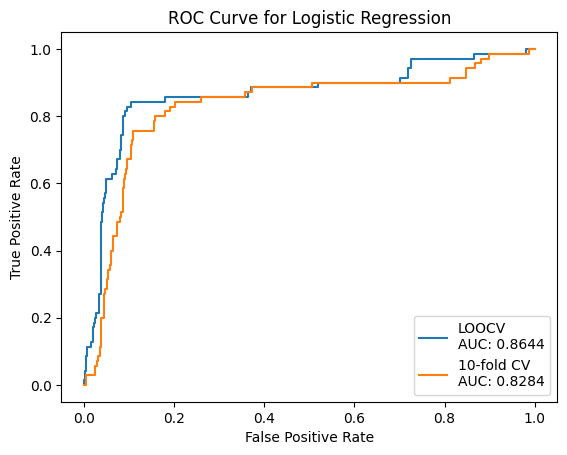

In [18]:
fpr_loo, tpr_loo, _ = metrics.roc_curve(y, probs_loo)
auc_loo = metrics.roc_auc_score(y, probs_loo)
fpr_10, tpr_10, _ = metrics.roc_curve(y, probs_10fold)
auc_10 = metrics.roc_auc_score(y, probs_10fold)
plt.plot(fpr_loo, tpr_loo, label=f"LOOCV\nAUC: {round(auc_loo,4)}")
plt.plot(fpr_10, tpr_10, label=f"10-fold CV\nAUC: {round(auc_10,4)}")
plt.legend(loc=4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Logistic Regression")
plt.show()

### h.

We have 5 columns hence there will be 2<sup>5</sup> = 32 subsets. But I ignore the intercept only model so we have 31 subsets to consider indeed. Since this number is not large and training logistic regression is super fast, I will try all possible subsets. In model evaluation, I use Akaike and Bayesian information criteria and pseudo (McFadden's) R<sup>2</sup> values, just like in the class.

In [19]:
from itertools import combinations
all_combinations = []
for i in range(len(X.columns)):
  for j in combinations(X.columns, i+1):
    all_combinations.append(list(j))

In [20]:
aics = []
bics = []
p_r2= []
for combo in all_combinations:
  temp_model = sm.Logit(y, sm.add_constant(X[combo])).fit()
  aics.append(temp_model.aic)
  bics.append(temp_model.bic)
  p_r2.append(temp_model.prsquared)
subset_res = pd.DataFrame(all_combinations, columns=["x1","x2","x3","x4","x5"]).fillna("-")
subset_res["AIC"] = aics
subset_res["BIC"] = bics
subset_res["Pseudo-R2"] = p_r2

Optimization terminated successfully.
         Current function value: 0.305202
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.270357
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.291036
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.242981
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.309789
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.270150
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.289199
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.242848
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.301767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.261541
  

In [21]:
print("Best subset acc. to AIC:\t", all_combinations[np.argmin(aics)])
print("Best subset acc. to BIC:\t", all_combinations[np.argmin(bics)])
print("Best subset acc. to pseudo R2:\t",all_combinations[np.argmax(p_r2)])

Best subset acc. to AIC:	 ['RE/TA', 'EBIT/TA', 'ME/TL', 'S/TA']
Best subset acc. to BIC:	 ['RE/TA', 'ME/TL']
Best subset acc. to pseudo R2:	 ['WC/TA', 'RE/TA', 'EBIT/TA', 'ME/TL', 'S/TA']


In [22]:
print("best subsets acc. to AIC:")
print(subset_res.sort_values("AIC").head())
print("\nbest subsets acc. to BIC:")
print(subset_res.sort_values("BIC").head())
print("\nbest subsets acc. to Pseudo-R2:")
print(subset_res.sort_values("Pseudo-R2", ascending=False).head())

best subsets acc. to AIC:
       x1       x2       x3     x4    x5         AIC         BIC  Pseudo-R2
29  RE/TA  EBIT/TA    ME/TL   S/TA     -  349.689158  372.749363   0.268059
30  WC/TA    RE/TA  EBIT/TA  ME/TL  S/TA  350.482634  378.154880   0.270659
21  RE/TA  EBIT/TA    ME/TL      -     -  351.173112  369.621276   0.260552
25  WC/TA    RE/TA  EBIT/TA  ME/TL     -  351.354966  374.415172   0.264469
23  RE/TA    ME/TL     S/TA      -     -  351.455922  369.904086   0.259942

best subsets acc. to BIC:
       x1       x2     x3    x4 x5         AIC         BIC  Pseudo-R2
10  RE/TA    ME/TL      -     -  -  351.885419  365.721542   0.254708
21  RE/TA  EBIT/TA  ME/TL     -  -  351.173112  369.621276   0.260552
23  RE/TA    ME/TL   S/TA     -  -  351.455922  369.904086   0.259942
16  WC/TA    RE/TA  ME/TL     -  -  352.924510  371.372674   0.256778
29  RE/TA  EBIT/TA  ME/TL  S/TA  -  349.689158  372.749363   0.268059

best subsets acc. to Pseudo-R2:
       x1       x2       x3     x4    

AIC only discards working capital which is not statistically significant as we know from regression summary in (a). BIC is harsh and only selects RE and ME but eliminates EBIT whose coefficient is highest (in absolute terms). So, we can rely AIC and select all variables other than working capital/total assets.

### i.

Although not required, feature scaling can be helpful.

In [23]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

Optimization terminated successfully.
         Current function value: 0.133074
         Iterations 11


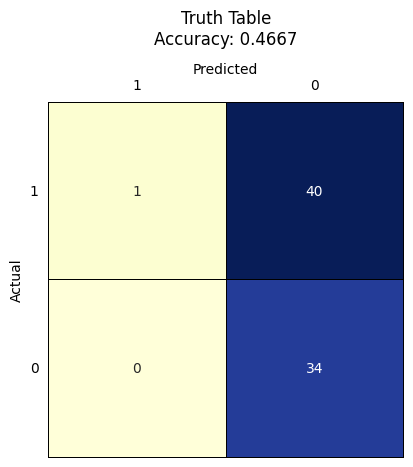

In [24]:
logit_model_sc = sm.Logit(y_train, sm.add_constant(X_train_sc)).fit()
y_pred_prob_sc = logit_model_sc.predict(sm.add_constant(X_test_sc))
y_pred_sc = [0 if p < 0.5 else 1 for p in y_pred_prob_sc]
my_truth_table(y_test, y_pred_sc, decimals=4)

Let's try sin transformation

Optimization terminated successfully.
         Current function value: 0.150641
         Iterations 8


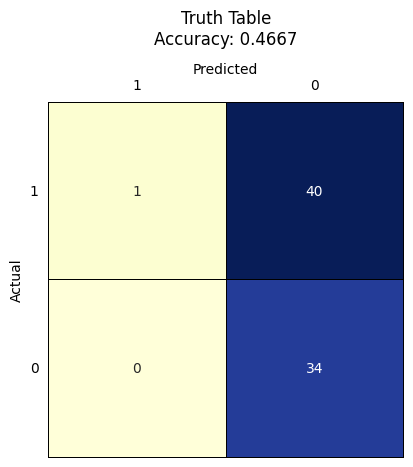

In [25]:
logit_model_sin = sm.Logit(y_train, sm.add_constant(np.sin(X_train))).fit()
y_pred_prob_sin = logit_model_sin.predict(sm.add_constant(np.sin(X_test)))
y_pred_sin = [0 if p < 0.5 else 1 for p in y_pred_prob_sin]
my_truth_table(y_test, y_pred_sin, decimals=4)

Optimization terminated successfully.
         Current function value: 0.132725
         Iterations 10


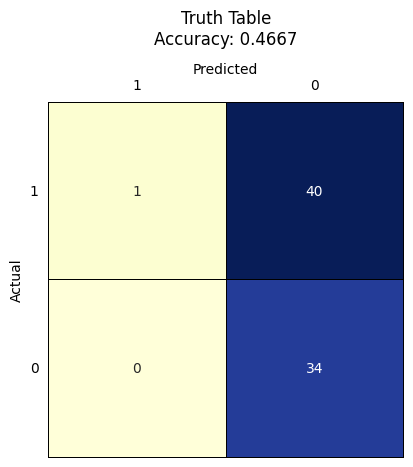

In [26]:
logit_model_sin_sc = sm.Logit(y_train, sm.add_constant(np.sin(X_train_sc))).fit()
y_pred_prob_sin_sc = logit_model_sin_sc.predict(sm.add_constant(np.sin(X_test_sc)))
y_pred_sin_sc = [0 if p < 0.5 else 1 for p in y_pred_prob_sin_sc]
my_truth_table(y_test, y_pred_sin_sc, decimals=4)

Unfortunately, these transformations couldn't help us.

## Part B: Lasso, Ridge and ElasticNet Regression

In shrinkage estimation, we need to scale features before fitting the models. One common way is z-score normalization a.k.a standard scaler. This is a classification model and I apply regularization methods to logistic regression via penalties.

In [27]:
X_scaled = StandardScaler().fit_transform(X)

### a.

In [28]:
lasso_reg = LogisticRegression(solver="liblinear", penalty="l1")  # l1 is lasso
ridge_reg = LogisticRegression(solver="lbfgs", penalty="l2")      # l2 is ridge
el_net = LogisticRegression(solver="saga", penalty="elasticnet", max_iter=2000)

In [29]:
lambdas = np.logspace(7, -3, 100) # a sequence from 10 million to 0.001
Cs = 1/lambdas  # inverse of regularization strength, smaller values (higher lambdas) specify stronger regularization.
ratios = np.linspace(0,1,11)
params = {"C": Cs}  # this is inverse of lambdas for lasso and ridge
el_params = {"C": Cs, "l1_ratio": ratios} # l1=1: lasso, l1=0: ridge

In [30]:
# I choose roc auc as scoring because when it is set to accuracy, the models predicts 0 for (almost) any case.
# moreover lasso zeroes all coefficients then the model becomes intercept only model which is meaningless.
lasso_grid = GridSearchCV(lasso_reg, params, scoring="roc_auc", cv=10)
lasso_grid.fit(X_scaled, y)
print("lambda for lasso: ", 1/lasso_grid.best_params_["C"])
print("lasso reg. coefs: ", lasso_grid.best_estimator_.coef_)

lambda for lasso:  0.3351602650938841
lasso reg. coefs:  [[ 0.13038547 -0.52053305 -0.26830815 -3.23989324  0.20316613]]


In [31]:
ridge_grid = GridSearchCV(ridge_reg, params, scoring="roc_auc", cv=10)
ridge_grid.fit(X_scaled, y)
print("lambda for ridge: ", 1/ridge_grid.best_params_["C"])
print("ridge reg. coefs: ", ridge_grid.best_estimator_.coef_)

lambda for ridge:  0.1668100537200059
ridge reg. coefs:  [[ 0.13600527 -0.53012247 -0.27899667 -3.21014753  0.20954841]]


In [32]:
elnet_grid = GridSearchCV(el_net, el_params, scoring="roc_auc", cv=10)
elnet_grid.fit(X_scaled, y)
print("lambda for elasticnet: ", 1/elnet_grid.best_params_["C"])
print("l1 ratio is: ", elnet_grid.best_params_["l1_ratio"])
print("elasticnet reg. coefs: ", elnet_grid.best_estimator_.coef_)

lambda for elasticnet:  0.42292428743894983
l1 ratio is:  1.0
elasticnet reg. coefs:  [[ 0.12863821 -0.5215075  -0.2683977  -3.23951527  0.20315414]]


Magnitudes and signs of coefficients are pretty much same for all regularization methods. Also, l1 ratio for ElasticNet is equal to 1, which is equivalent to Lasso estimation. Just like in logistic regression, the signs of the 2nd, 3rd and 4th variables (retained earnings, EBIT and market value) are negative, which means that higher levels of these variables reduce the risk of default. However, their magnitudes are changed due to the z-score transformation and 4th variable (market value) is the most important factor amongst others. Coefficients of 1st and 5th variables (working capital and sales) has positive sign but their absolute value are the lowest.

### b.

In grid search, I've used 10-fold cross validation.

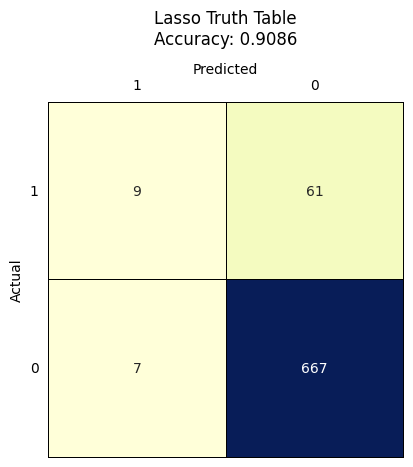

In [33]:
my_truth_table(y, lasso_grid.predict(X_scaled), title="Lasso Truth Table", decimals=4)

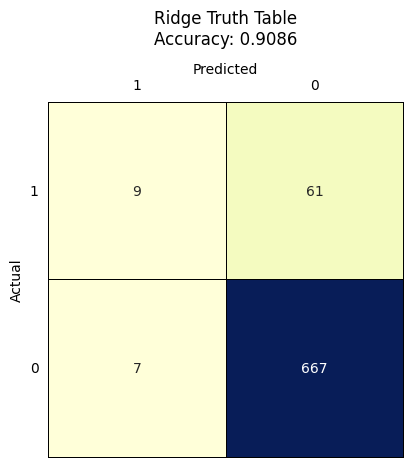

In [34]:
my_truth_table(y, ridge_grid.predict(X_scaled), title="Ridge Truth Table", decimals=4)

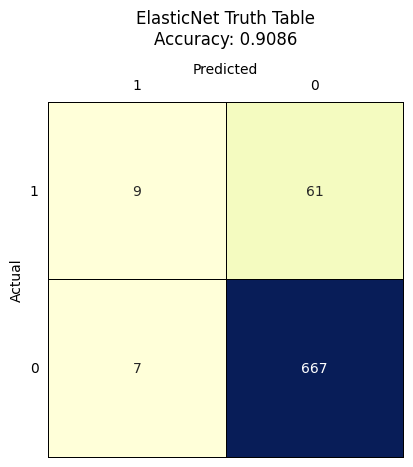

In [35]:
my_truth_table(y, elnet_grid.predict(X_scaled), title="ElasticNet Truth Table", decimals=4)

### c. - d.

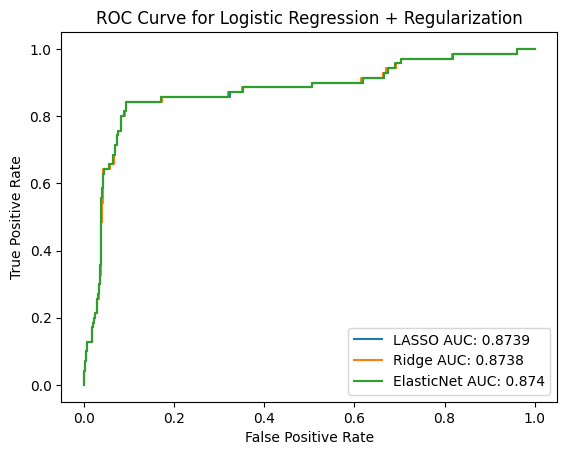

In [36]:
# roc stats for lasso
fpr1, tpr1, _ = metrics.roc_curve(y, lasso_grid.predict_proba(X_scaled)[:,1])
auc1 = metrics.roc_auc_score(y, lasso_grid.predict_proba(X_scaled)[:,1])
# roc stats for ridge
fpr2, tpr2, _ = metrics.roc_curve(y, ridge_grid.predict_proba(X_scaled)[:,1])
auc2 = metrics.roc_auc_score(y, ridge_grid.predict_proba(X_scaled)[:,1])
# roc stats for elasticnet
fpr3, tpr3, _ = metrics.roc_curve(y, elnet_grid.predict_proba(X_scaled)[:,1])
auc3 = metrics.roc_auc_score(y, elnet_grid.predict_proba(X_scaled)[:,1])
# roc curves
plt.plot(fpr1, tpr1, label=f"LASSO AUC: {round(auc1,4)}")
plt.plot(fpr2, tpr2, label=f"Ridge AUC: {round(auc2,4)}")
plt.plot(fpr3, tpr3, label=f"ElasticNet AUC: {round(auc3,4)}")
plt.legend(loc=4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Logistic Regression + Regularization")
plt.show()

According to ROC, ElasticNet is better but ROC curves are almost the same for all three regularization methods, hence AUC score are super close to each other.

## Part C: Unsupervised Learning

### a.

In [37]:
yields = pd.read_csv("turkish_yields.csv", index_col=0, parse_dates=True, dayfirst=True)
yields_diff = yields.diff().dropna()

In [38]:
def moments(series):
  df = pd.DataFrame(series)
  return pd.DataFrame({"mean": np.mean(df,axis=0),
                       "std. deviation": np.std(df),
                       "skewness": df.apply(skew, nan_policy="omit"),
                       "excess kurtosis": df.apply(kurtosis, nan_policy="omit")}).T

In [39]:
print("Descriptive Stats for Turkish interest rates (level):\n")
moments(yields)

Descriptive Stats for Turkish interest rates (level):



,X30,X90,X180,X360,X720,X1080,X1800,X2520,X3600
mean,11.555316,11.689976,11.834735,11.989251,12.043765,11.993279,11.849195,11.710016,11.530420
std. deviation,5.089208,4.961375,4.831712,4.681694,4.456182,4.251755,3.887685,3.564137,3.157895
skewness,1.339858,1.293306,1.239529,1.192387,1.164402,1.145685,1.095237,1.005542,0.885256
excess kurtosis,1.335607,1.145244,0.958921,0.860450,0.889645,0.884570,0.743231,0.395706,0.034079


In [40]:
print("Descriptive Stats for Turkish interest rates differences (r(t)-r(t-1)):\n")
moments(yields_diff)

Descriptive Stats for Turkish interest rates differences (r(t)-r(t-1)):



,X30,X90,X180,X360,X720,X1080,X1800,X2520,X3600
mean,0.003305,0.003518,0.003845,0.004366,0.004897,0.005092,0.005096,0.004829,0.004197
std. deviation,0.620385,0.481463,0.336411,0.229683,0.241680,0.260978,0.261968,0.245382,0.306240
skewness,0.644185,0.315979,-0.120206,0.542975,0.820461,1.491347,2.928378,4.168187,2.057150
excess kurtosis,26.611566,23.573654,21.115303,26.660699,37.647837,40.709215,64.129704,100.167567,50.913998


### b.

In [41]:
yields_monthly = yields.resample("M").mean()
yields_monthly.index = yields_monthly.index.to_period("M")
yields_monthly["r(10)-r(2)"] = yields_monthly["X3600"] - yields_monthly["X720"]
yields_monthly

,X30,X90,X180,X360,X720,X1080,X1800,X2520,X3600,r(10)-r(2)
2011-05,7.328695,7.685247,8.042605,8.481432,8.930368,9.152747,9.407837,9.555884,9.684537,0.754168
2011-06,7.602545,7.963350,8.321550,8.778873,9.199977,9.376245,9.546745,9.627291,9.675177,0.475200
2011-07,7.833595,8.046348,8.316905,8.707833,9.129567,9.350771,9.613338,9.765867,9.897586,0.768019
2011-08,7.115343,7.353048,7.621090,7.987429,8.407210,8.655505,9.002814,9.261614,9.567210,1.160000
2011-09,6.896833,7.307276,7.670948,8.043600,8.326767,8.464543,8.770786,9.185486,9.908405,1.581638
...,...,...,...,...,...,...,...,...,...,...
2021-08,19.880428,19.641721,19.347990,18.952656,18.527255,18.250225,17.840762,17.530494,17.151055,-1.376200
2021-09,18.744005,18.584245,18.403747,18.198757,18.074101,18.016806,17.882243,17.687384,17.317244,-0.756857
2021-10,17.647876,17.718748,17.831115,18.085387,18.623568,19.101128,19.718873,19.945145,19.853000,1.229432
2021-11,16.364719,16.712959,17.176852,17.980631,19.104523,19.833331,20.584527,20.686467,20.191996,1.087472


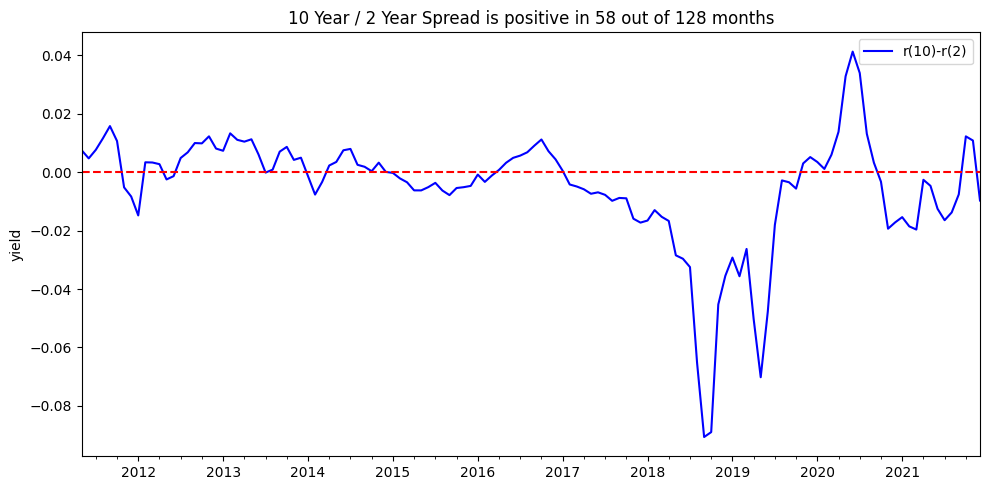

In [42]:
(yields_monthly["r(10)-r(2)"]/100).plot(figsize=(10,5), color="blue")
plt.axhline(y=0, color="red", linestyle="--")
plt.title(f'10 Year / 2 Year Spread is positive in {sum(yields_monthly["r(10)-r(2)"]>0)} out of {len(yields_monthly)} months')
plt.ylabel("yield")
plt.legend()
plt.tight_layout()
plt.show()

### c. - d.

In [43]:
yields_yearly = yields.resample("Y").mean()
yields_yearly.index = yields_yearly.index.to_period("Y")
yields_yearly

,X30,X90,X180,X360,X720,X1080,X1800,X2520,X3600
2011,7.950945,8.317936,8.648552,8.962373,9.220063,9.310094,9.458910,9.593084,9.779516
2012,8.017224,8.202362,8.351089,8.413042,8.419525,8.449544,8.531751,8.623771,8.766308
2013,6.610742,6.776916,6.973208,7.240948,7.523632,7.672063,7.873069,8.031334,8.233294
2014,9.203434,9.226404,9.255463,9.296600,9.332505,9.345854,9.369975,9.404970,9.474419
2015,9.313274,9.408264,9.521731,9.658702,9.707028,9.654882,9.516081,9.392002,9.242848
2016,8.979111,9.137864,9.338520,9.623376,9.896234,10.023937,10.163153,10.235561,10.291647
2017,11.446274,11.552508,11.674851,11.805252,11.789420,11.667361,11.413547,11.207915,10.980671
2018,17.685318,18.053985,18.467559,18.870715,18.721479,18.219455,17.111791,16.096849,14.763136
2019,19.616982,19.296937,18.879230,18.248263,17.461094,16.926865,16.169868,15.663354,15.138944
2020,10.391668,10.677812,11.046506,11.589731,12.168368,12.465699,12.779980,12.918967,13.030540


In [44]:
yield_curve_df = yields_yearly.reset_index(names="year").melt(id_vars=["year"], var_name="maturity", value_name="yield")
yield_curve_df["maturity"] = yield_curve_df["maturity"].str.replace("X", "").astype(int)
yield_curve_df

,year,maturity,yield
0,2011,30,7.950945
1,2012,30,8.017224
2,2013,30,6.610742
3,2014,30,9.203434
4,2015,30,9.313274
...,...,...,...
94,2017,3600,10.980671
95,2018,3600,14.763136
96,2019,3600,15.138944
97,2020,3600,13.030540


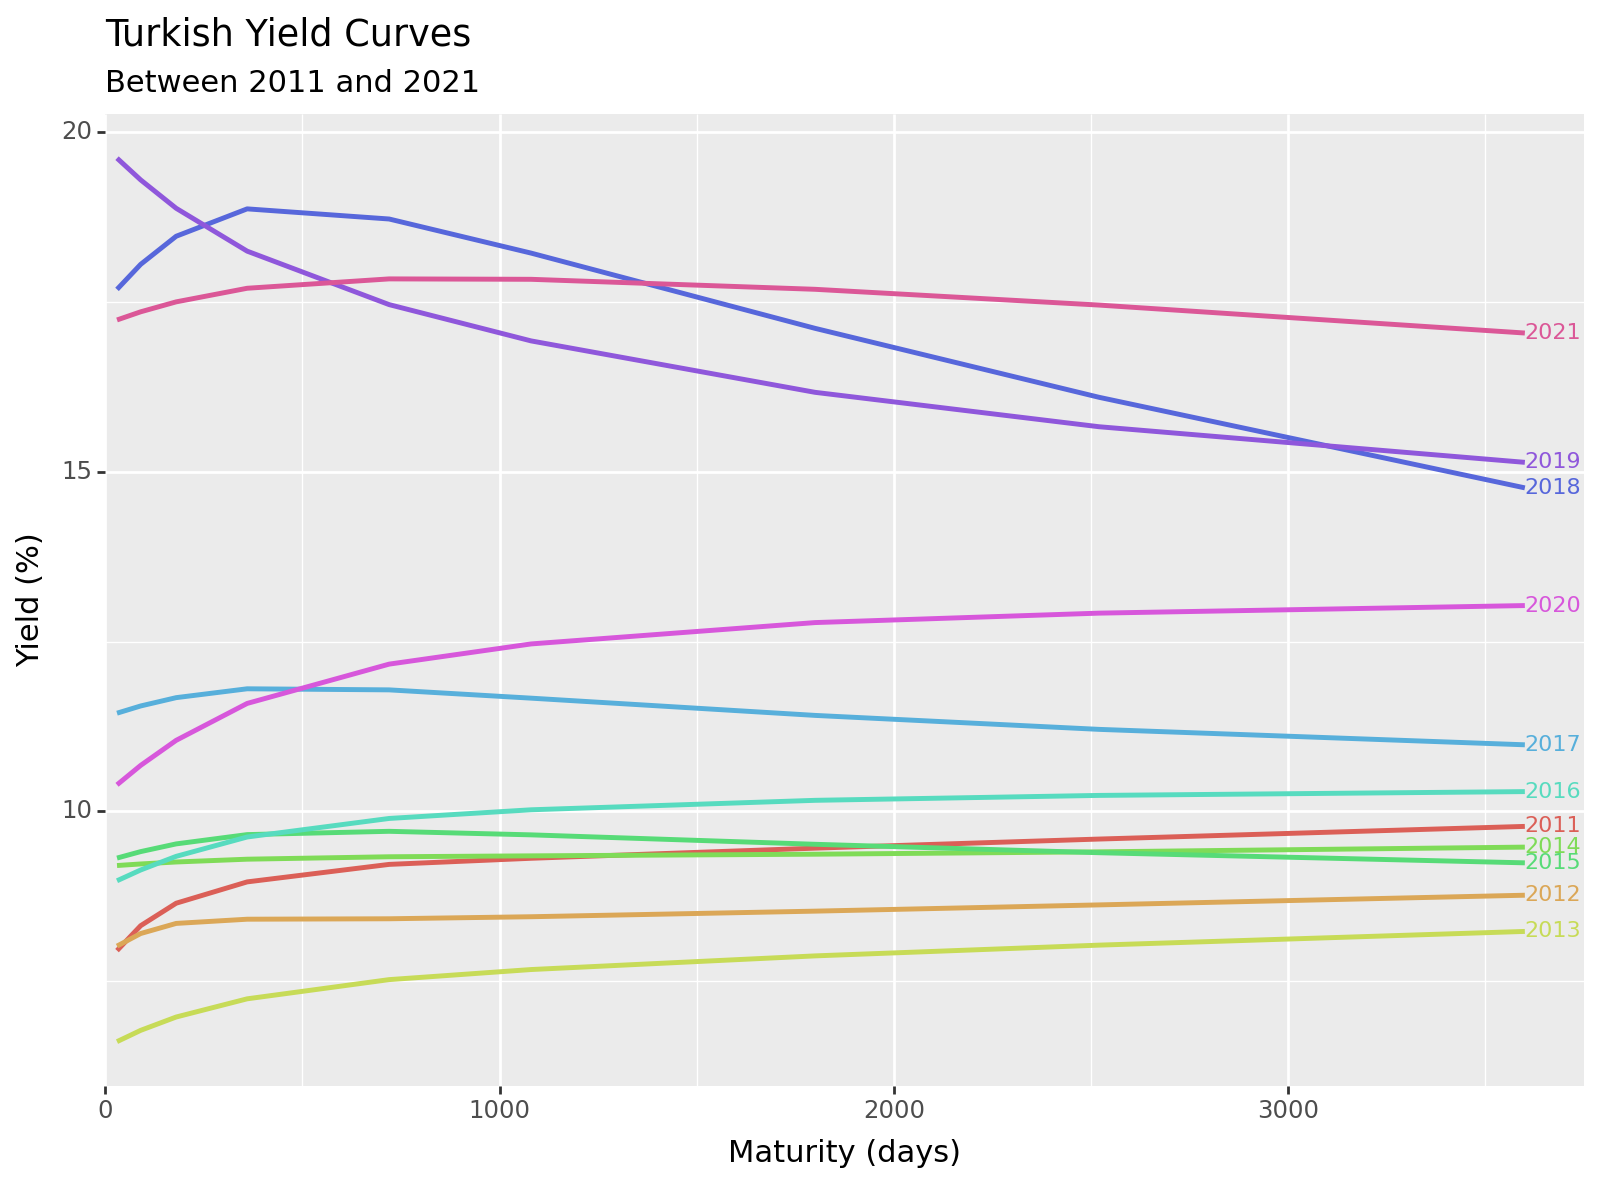

<Figure Size: (800 x 600)>

In [45]:
(ggplot(aes(x="maturity", y="yield", color="year")) +
 geom_line(yield_curve_df, size=1) +
 geom_text(yield_curve_df[yield_curve_df["maturity"]==3600], aes(label="year"), size=8, nudge_x=70) +
 theme(legend_position="none", figure_size=(8,6)) +
 labs(title="Turkish Yield Curves", subtitle="Between 2011 and 2021", x="Maturity (days)", y="Yield (%)") +
 scale_x_continuous(expand=(0,0), limits=(0,3750))
)

Flat yield curves:
*   No significant difference between short term and long term interest rates.
*   In 2012, 2014, 2015, 2017, yield curves are flat.
*   It is difficult for the market to determine whether interest rates will move significantly in either direction farther into the future.
*   Investors might want to use barbell strategy in that period (short and long term but no middle term).



Steep yield curves:
*   There is a large spread between short and long term interest rates.
*   2020 yield curve is an example of this.
*   It maybe an indicator of high inflation rate for future.
*   So, longer term bonds are riskier.

### e.

In [46]:
yields_monthly_diff = (yields_monthly.iloc[:,:9]/100).diff().dropna()
print("Variance-Covariance of Monthly Yields Differences:\n")
yields_monthly_diff.cov()

Variance-Covariance of Monthly Yields Differences:



,X30,X90,X180,X360,X720,X1080,X1800,X2520,X3600
X30,0.000237,0.000210,0.000176,0.000130,0.000088,0.000070,0.000047,0.000031,0.000012
X90,0.000210,0.000191,0.000166,0.000133,0.000101,0.000084,0.000061,0.000043,0.000021
X180,0.000176,0.000166,0.000154,0.000137,0.000116,0.000102,0.000078,0.000058,0.000032
X360,0.000130,0.000133,0.000137,0.000139,0.000134,0.000124,0.000101,0.000078,0.000046
X720,0.000088,0.000101,0.000116,0.000134,0.000142,0.000138,0.000119,0.000095,0.000057
X1080,0.000070,0.000084,0.000102,0.000124,0.000138,0.000138,0.000123,0.000101,0.000061
X1800,0.000047,0.000061,0.000078,0.000101,0.000119,0.000123,0.000117,0.000099,0.000064
X2520,0.000031,0.000043,0.000058,0.000078,0.000095,0.000101,0.000099,0.000088,0.000062
X3600,0.000012,0.000021,0.000032,0.000046,0.000057,0.000061,0.000064,0.000062,0.000058


In [47]:
def pca_results(X, title=""):
  X_scaled = StandardScaler().fit_transform(X)
  pca = PCA()
  pca.fit(X_scaled)

  pve = pca.explained_variance_ratio_.round(2)
  pve_cumsum = pca.explained_variance_ratio_.cumsum()

  pc_list = ["PC" + str(i) for i in range(1, X.shape[1] + 1)]
  factor_loadings = pd.DataFrame(pca.components_, columns=X.columns, index=pc_list).round(3).T

  print("Explained variance ratio:\n", pve, "\n")
  print("Cumulative explained variance ratio:\n", pve_cumsum, "\n")
  print(factor_loadings, "\n")

  fig = (ggplot(aes(x=range(1, len(pve)+1), y=pve)) +
    geom_col(fill = "#E56717",color="#004225", size=1) +
    geom_text(aes(label=pve), position=position_dodge(width = .9), va="bottom") +
    scale_x_continuous(breaks=range(1, len(pve)+1)) +
    theme(panel_grid_major_x=element_blank(), panel_grid_minor_x=element_blank(),
          axis_text_x=element_text(color="black", size=10),
          axis_text_y=element_text(color="black", size=10), figure_size=(7,5)) +
    labs(title=f"Percentage of Yield Curve Explained by Factors {title}",
         x="Principal Component", y="Variance Explained")
    )

  print(fig)

In [48]:
yields_monthly_2013 = yields_monthly_diff[yields_monthly_diff.index.year == 2013]
yields_monthly_2018 = yields_monthly_diff[yields_monthly_diff.index.year == 2018]
yields_monthly_2019 = yields_monthly_diff[yields_monthly_diff.index.year == 2019]

Explained variance ratio:
 [0.94 0.05 0.02 0.   0.   0.   0.   0.   0.  ] 

Cumulative explained variance ratio:
 [0.93564037 0.98283455 0.99836975 0.99994942 0.99999821 0.99999959
 0.9999999  1.         1.        ] 

         PC1    PC2    PC3    PC4    PC5    PC6    PC7    PC8    PC9
X30    0.309  0.677  0.052 -0.105  0.559 -0.310 -0.078  0.135  0.010
X90    0.329  0.459 -0.079  0.070 -0.248  0.586  0.270 -0.437 -0.042
X180   0.341  0.181 -0.227  0.193 -0.555 -0.035 -0.415  0.521  0.092
X360   0.340 -0.150 -0.366  0.266 -0.141 -0.624  0.307 -0.340 -0.197
X720   0.334 -0.327 -0.355  0.123  0.382  0.257  0.241  0.212  0.571
X1080  0.337 -0.301 -0.216 -0.163  0.285  0.288 -0.296  0.057 -0.684
X1800  0.341 -0.176  0.124 -0.550 -0.123 -0.133 -0.413 -0.438  0.373
X2520  0.339 -0.116  0.410 -0.419 -0.210 -0.058  0.557  0.391 -0.133
X3600  0.330 -0.185  0.671  0.597  0.108  0.029 -0.168 -0.099  0.012 



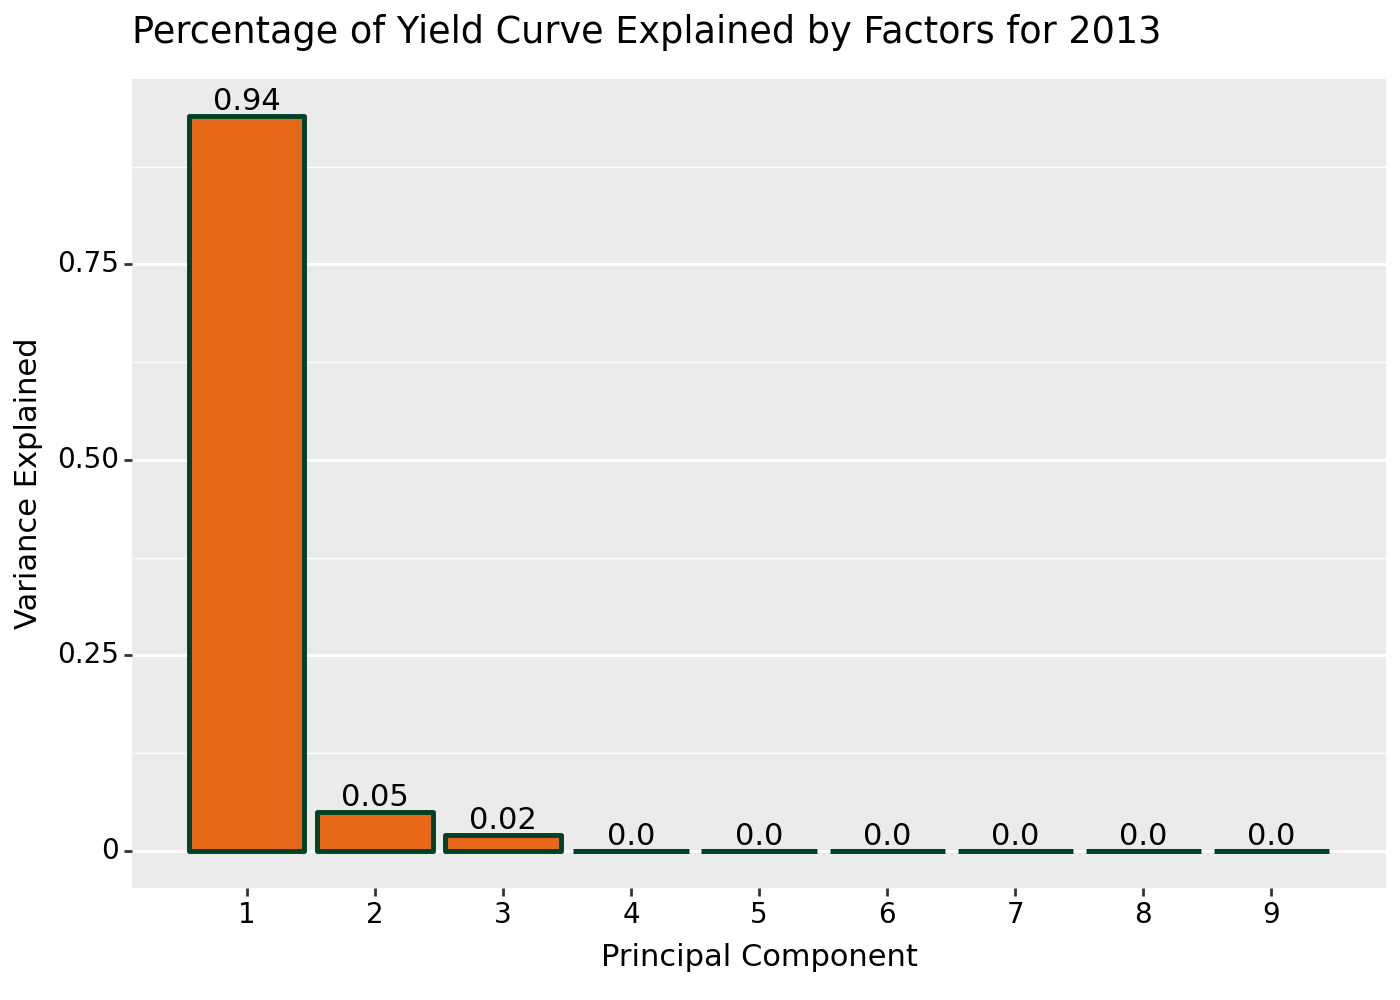

In [49]:
pca_results(yields_monthly_2013, title="for 2013")

For year 2013:
*   We can capture 98% of variance by the first two principal components (numbers in the plot are rounded, so it's not 99% as shown in the plot).
*   **PC1**: This suggests/represents that short term and long term interest rates move in a parallel way since all coefficients have same sign. Also, magnitudes of the coefficients are similar. This is the most dominant factor by far (94%).
*   **PC2**: Up to 1 year, coefficients are positive and after that period they become negative. So this component captures opposite movements of short term and long term interest rates.
*   These conclusions also match the yield curve for 2013 from the previous part.

Explained variance ratio:
 [0.66 0.29 0.04 0.01 0.   0.   0.   0.   0.  ] 

Cumulative explained variance ratio:
 [0.66487116 0.95627653 0.99310481 0.99997281 0.9999976  0.99999986
 0.99999997 0.99999999 1.        ] 

         PC1    PC2    PC3    PC4    PC5    PC6    PC7    PC8    PC9
X30   -0.226  0.508  0.131 -0.424 -0.382  0.068 -0.394 -0.220  0.374
X90   -0.273  0.455  0.137 -0.210 -0.046 -0.054  0.703  0.365 -0.153
X180  -0.337  0.346  0.128  0.117  0.449  0.050 -0.373 -0.139 -0.611
X360  -0.397  0.125  0.040  0.510  0.390 -0.068  0.076 -0.017  0.634
X720  -0.401 -0.089 -0.160  0.388 -0.590 -0.503 -0.090  0.027 -0.215
X1080 -0.387 -0.176 -0.258  0.109 -0.227  0.760  0.201 -0.253 -0.089
X1800 -0.360 -0.268 -0.296 -0.323  0.148  0.067 -0.327  0.683  0.080
X2520 -0.339 -0.335 -0.136 -0.485  0.257 -0.377  0.224 -0.511  0.014
X3600 -0.220 -0.420  0.865 -0.026 -0.105  0.091 -0.033  0.081 -0.008 



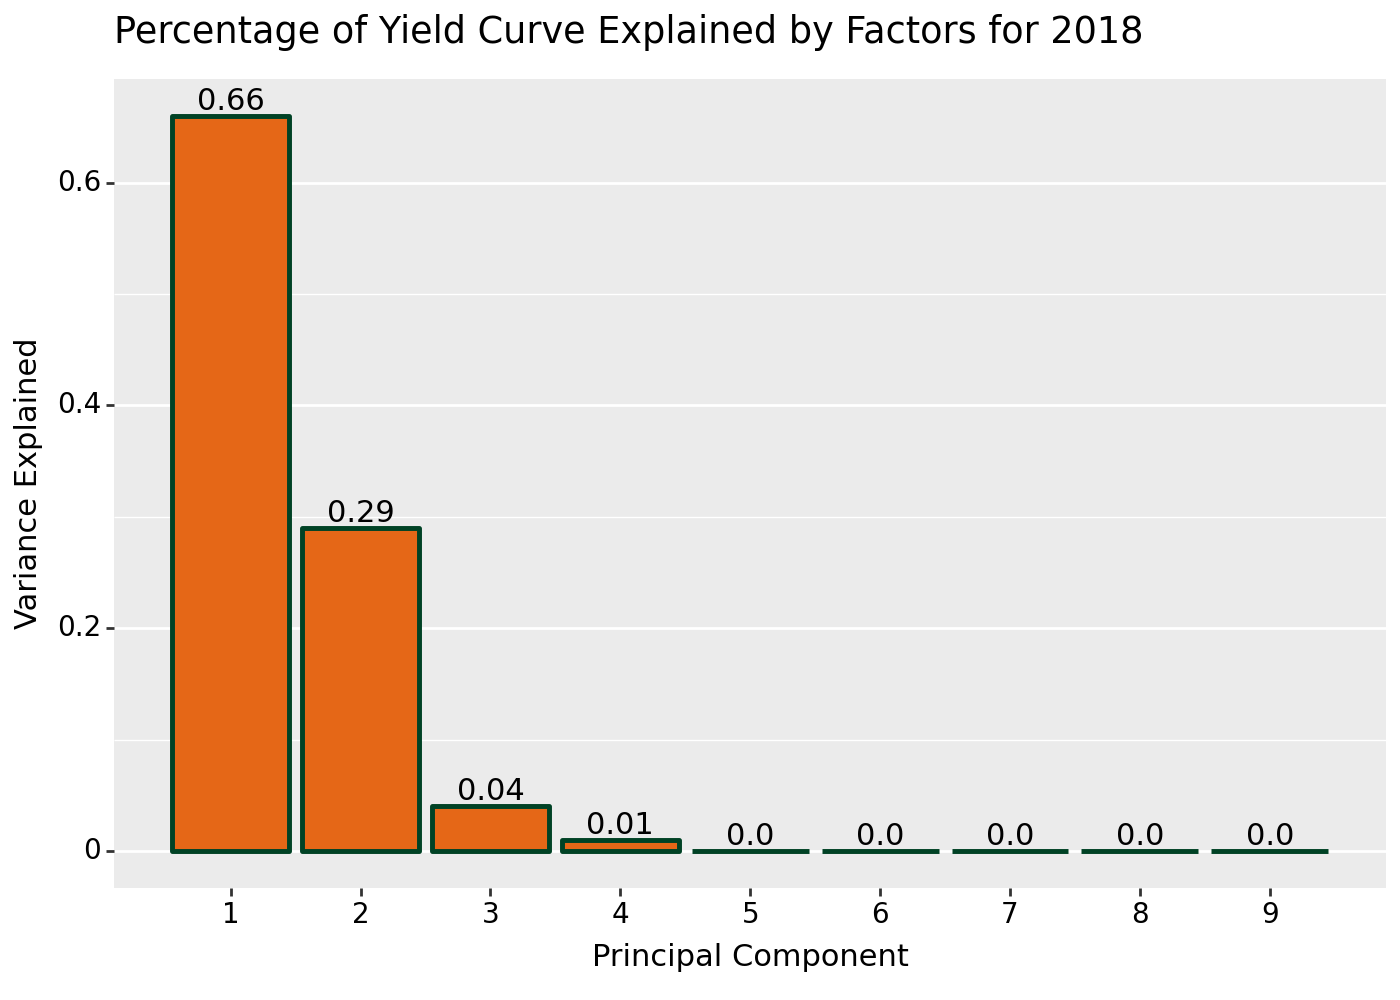

In [50]:
pca_results(yields_monthly_2018, "for 2018")

For year 2018:
*   We can capture 99% of the total variability by the first three principal components.
*   **PC1**: All coefficients have same signs, all interest rates move in same direction but their magnitudes differ. Medium term (for instance 2 year) is more sensitive than 1-month and 10-year interest rates. But this relation is less dominant compared to 2013.
*   **PC2**: This captures opposite movements of interest rates. 2 year and longer term interest rates moves in an opposite way of short term interest rates. This relationship is much more effective, unlike 2013.
*   **PC3**: This component gives hump shape, which is negligible in 2013 yields.





Explained variance ratio:
 [0.77 0.17 0.05 0.01 0.   0.   0.   0.   0.  ] 

Cumulative explained variance ratio:
 [0.768219   0.94173874 0.98764227 0.99997315 0.99999659 0.99999955
 0.99999988 0.99999998 1.        ] 

         PC1    PC2    PC3    PC4    PC5    PC6    PC7    PC8    PC9
X30    0.252 -0.579  0.291 -0.167 -0.419 -0.390 -0.234 -0.310 -0.098
X90    0.299 -0.489  0.136 -0.015 -0.016  0.310  0.586  0.455  0.079
X180   0.347 -0.317 -0.100  0.193  0.474  0.405 -0.564 -0.089  0.132
X360   0.367 -0.034 -0.364  0.356  0.357 -0.497  0.351 -0.216 -0.246
X720   0.358  0.164 -0.403  0.164 -0.441 -0.215 -0.250  0.453  0.384
X1080  0.360  0.209 -0.281 -0.125 -0.391  0.485  0.044 -0.242 -0.531
X1800  0.358  0.236  0.018 -0.498  0.120  0.019  0.229 -0.409  0.578
X2520  0.347  0.265  0.298 -0.441  0.307 -0.229 -0.203  0.448 -0.371
X3600  0.292  0.356  0.651  0.569 -0.123  0.075  0.043 -0.109  0.073 



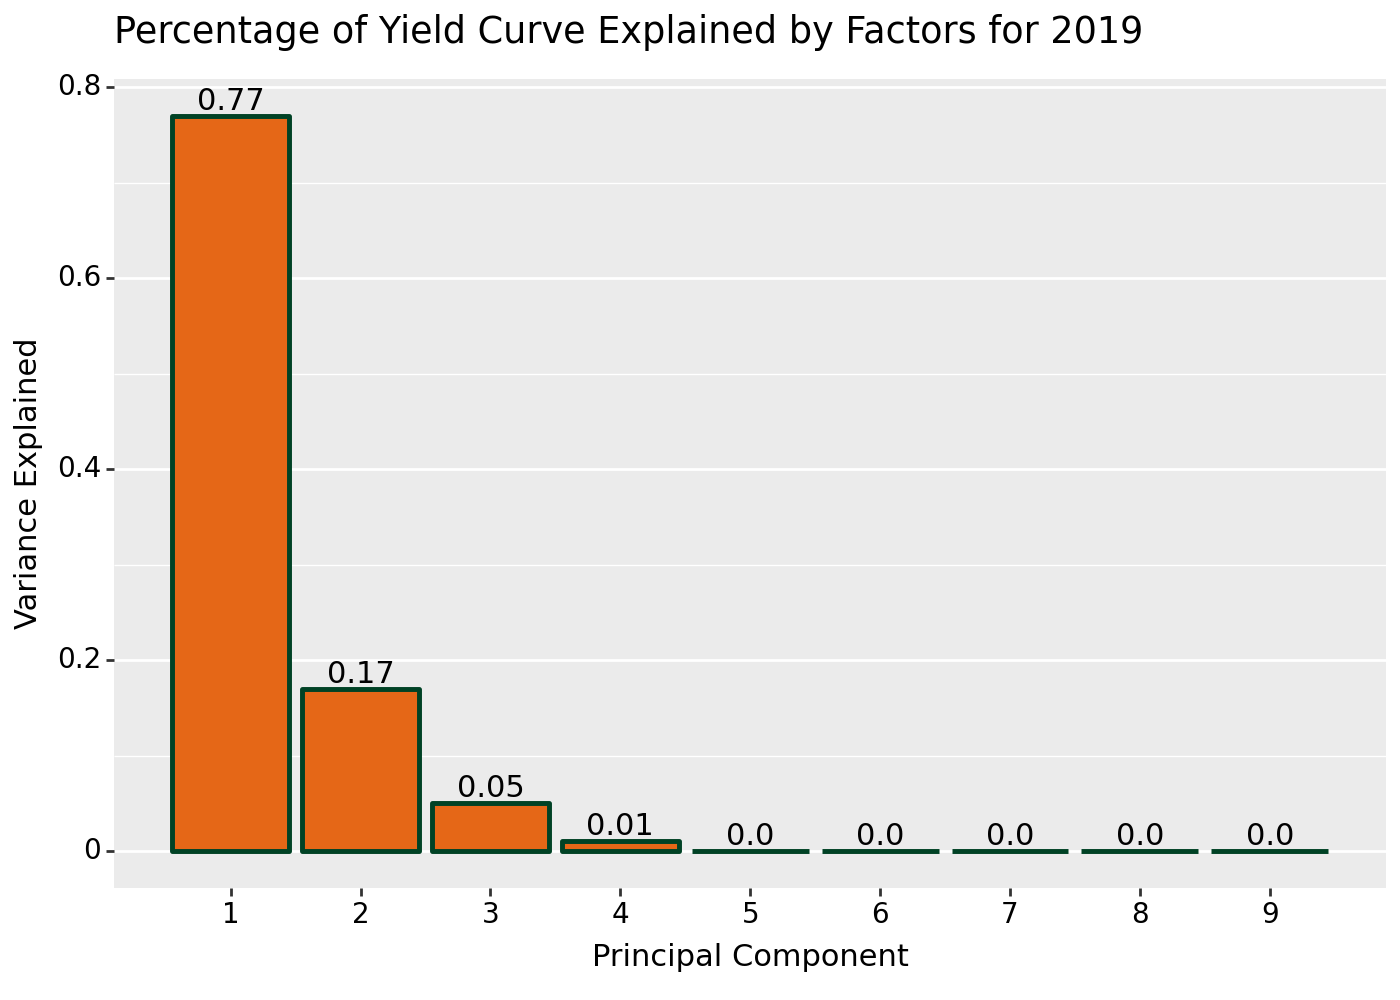

In [51]:
pca_results(yields_monthly_2019, "for 2019")

For year 2019:
*   Almost 99% of the total variability can be captured by three principal components.
*   The interpretation of the components are pretty much same as in 2018. The difference comes from explained variance ratios. The first principal component, which captures parallel movements of short term and long term interest rates, has higher PVE, and the second component (opposite movements) has lower PVE, compared to PCA for 2018 yields.


## Part D: Neural Net

In [52]:
logit1 = pd.read_csv("logit1.csv")
y = logit1["default"]
X = logit1.drop("default", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =.2, random_state=0)

### a.

In [53]:
def NNmodel(neurons):
  """
  a vanilla neural network model with single hidden layer
  """
  inputs = tf.keras.Input(shape=(None, 5))
  hidden = tf.keras.layers.Dense(units=neurons, activation="relu")(inputs)
  outputs = tf.keras.layers.Dense(units=1, activation="sigmoid")(hidden)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  return model

In [54]:
tf.keras.utils.set_random_seed(0) # for reproducibility
NN1_model = NNmodel(1)
NN2_model = NNmodel(2)
NN3_model = NNmodel(3)
nn_dict={"1 neuron": NN1_model,
         "2 neurons": NN2_model,
         "3 neurons": NN3_model}

for name, mdl in nn_dict.items():
  print(f"NN with {name}")
  mdl.compile(optimizer="adam",
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=["accuracy","AUC"])
  mdl.fit(X_train, y_train, epochs=10)
  test_loss, test_acc, test_auc = mdl.evaluate(X_test, y_test, verbose=2)
  print("\nTest accuracy:", round(test_acc,4))
  print("Test AUC:", test_auc, "\n")

NN with 1 neuron
Epoch 1/10
100/100 [==============================] - 1s 2ms/step - loss: 0.6697 - accuracy: 0.9825 - auc: 0.3575
Epoch 2/10
100/100 [==============================] - 0s 2ms/step - loss: 0.6249 - accuracy: 0.9825 - auc: 0.3751
Epoch 3/10
100/100 [==============================] - 0s 2ms/step - loss: 0.5833 - accuracy: 0.9825 - auc: 0.2966
Epoch 4/10
100/100 [==============================] - 0s 3ms/step - loss: 0.5437 - accuracy: 0.9825 - auc: 0.2107
Epoch 5/10
100/100 [==============================] - 0s 3ms/step - loss: 0.4720 - accuracy: 0.9825 - auc: 0.2082
Epoch 6/10
100/100 [==============================] - 0s 3ms/step - loss: 0.2499 - accuracy: 0.9825 - auc: 0.4370
Epoch 7/10
100/100 [==============================] - 0s 4ms/step - loss: 0.1411 - accuracy: 0.9825 - auc: 0.6199
Epoch 8/10
100/100 [==============================] - 0s 3ms/step - loss: 0.1103 - accuracy: 0.9825 - auc: 0.6964
Epoch 9/10
100/100 [==============================] - 0s 2ms/step - los

NN with 1 neuron



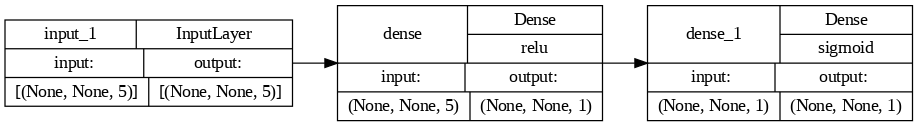

In [55]:
print("NN with 1 neuron\n")
tf.keras.utils.plot_model(NN1_model, show_shapes=True, rankdir="LR",
                          dpi=90, show_layer_activations=True)

NN with 2 neurons



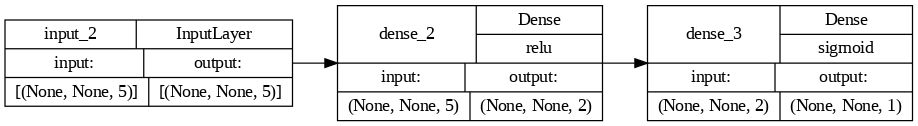

In [56]:
print("NN with 2 neurons\n")
tf.keras.utils.plot_model(NN2_model, show_shapes=True, rankdir="LR",
                          dpi=90, show_layer_activations=True)

NN with 3 neurons



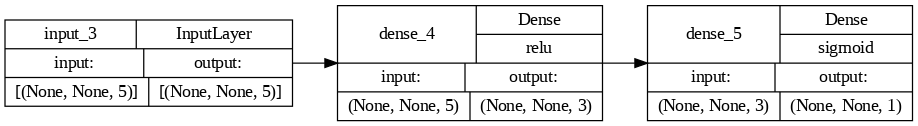

In [57]:
print("NN with 3 neurons\n")
tf.keras.utils.plot_model(NN3_model, show_shapes=True, rankdir="LR",
                          dpi=90, show_layer_activations=True)

### b.

25/25 [==============================] - 0s 2ms/step


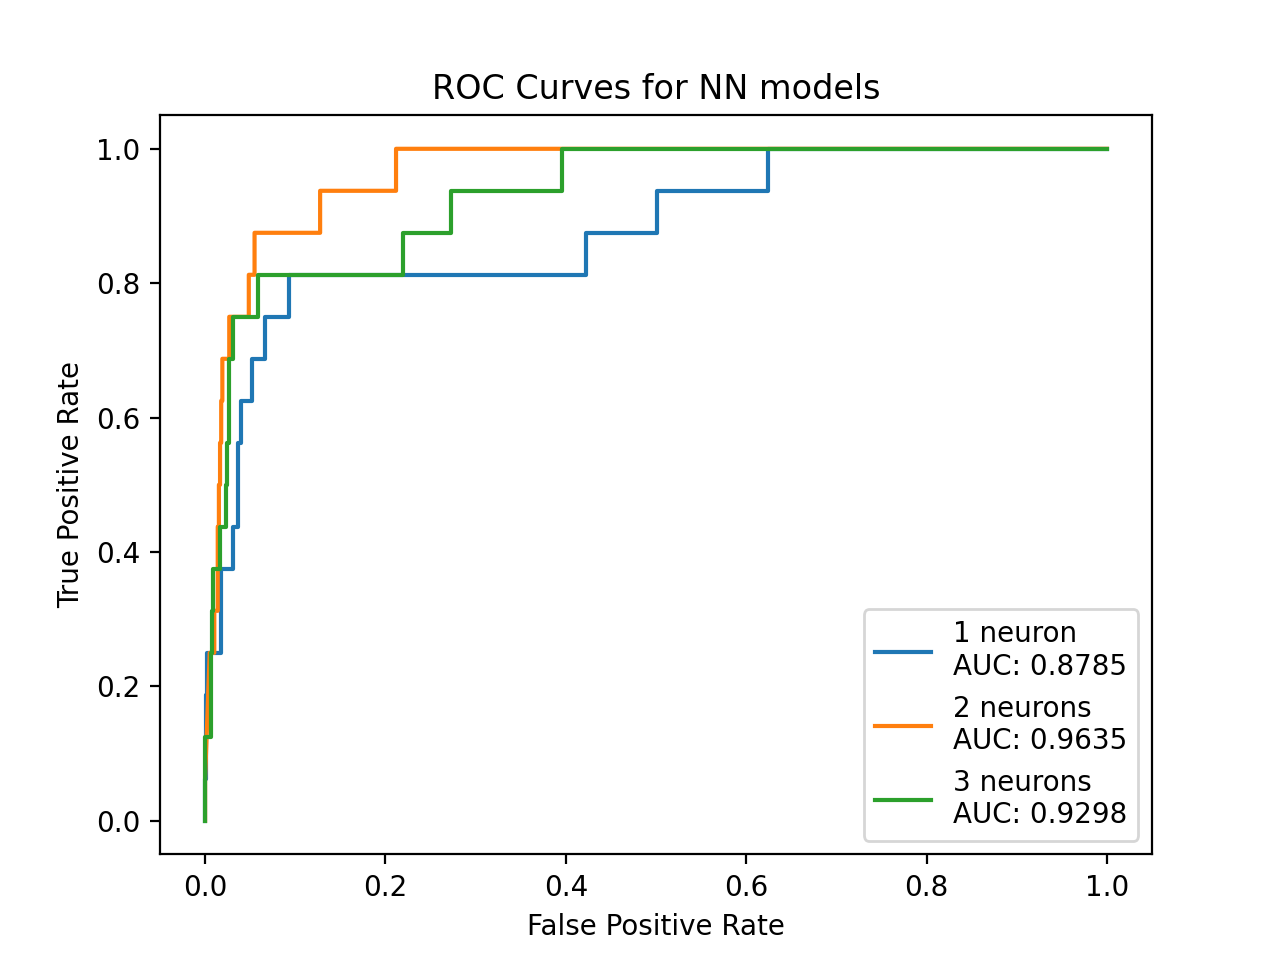

In [58]:
for name, mdl in nn_dict.items():
  probs = mdl.predict(X_test).flatten()
  fpr, tpr, _ = metrics.roc_curve(y_test, probs)
  auc = metrics.roc_auc_score(y_test, probs)
  plt.plot(fpr,tpr,label=f"{name}\nAUC: {round(auc,4)}")
plt.legend(loc=4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for NN models")
plt.show()

### c.

According to the area under the ROC curve, the model with 2 neurons in the hidden layer is the best one.

### d.

We can choose the threshold by finding the point on the ROC curve with minimum distance from the upper left corner but I want to test every percentage as threshold. So I created the table contains thresholds as index and accuracy rate on the columns.

In [59]:
thresholds = np.linspace(0.01,1,100)
acc_df = pd.DataFrame(columns=["1 neuron", "2 neurons", "3 neurons"],
                      index=thresholds)
for name, mdl in nn_dict.items():
  probs = mdl.predict(X_test).flatten()
  for threshold in thresholds:
    y_pred = [0 if prob < threshold else 1 for prob in probs]
    acc_df.loc[threshold,name] = metrics.accuracy_score(y_test, y_pred)

25/25 [==============================] - 0s 2ms/step


In [60]:
for name in nn_dict.keys():
  print(f"NN with {name} accuracy with optimal threshold:")
  print(acc_df[acc_df[name] == acc_df[name].max()],"\n")

NN with 1 neuron accuracy with optimal threshold:
    1 neuron 2 neurons 3 neurons
0.1   0.9825   0.87375    0.9775 

NN with 2 neurons accuracy with optimal threshold:
     1 neuron 2 neurons 3 neurons
0.37     0.98   0.98125      0.98
0.38     0.98   0.98125      0.98
0.39     0.98   0.98125      0.98 

NN with 3 neurons accuracy with optimal threshold:
     1 neuron 2 neurons 3 neurons
0.17     0.98     0.965    0.9825
0.18     0.98      0.97    0.9825
0.19     0.98   0.97375    0.9825 



*   For the 1st model, 98.25% accuracy can be reached by choosing threshold as 0.10.
*   For the second model, setting threshold either 0.37, 0.38 or 0.39 will produce 98.125% accuracy.
*   For the 3 neurons model, 98.25% accuracy can be reached by picking p = 0.17, 0.18 or 0.19.
*   Note that in this train-test splitting, 98% accuracy can be obtained by predicting all 0's. So, there is just slight improvement on accuracy rate.


## Part E: Decision Tree

In [61]:
logit1 = pd.read_csv("logit1.csv")
logit1.head(10)

,default,WCTA,RETA,EBITTA,METL,STA
0,0,0.501,0.307,0.043,0.956,0.335
1,0,0.550,0.320,0.050,1.060,0.330
2,0,0.450,0.230,0.030,0.800,0.250
3,0,0.310,0.190,0.030,0.390,0.250
4,0,0.450,0.220,0.030,0.790,0.280
5,0,0.460,0.220,0.030,1.290,0.320
6,0,0.010,-0.030,0.010,0.110,0.250
7,0,-0.110,-0.120,0.030,0.150,0.320
8,0,0.060,-0.110,0.040,0.410,0.290
9,0,0.050,-0.090,0.050,0.250,0.340


In [62]:
y = logit1["default"]
X = logit1.drop("default", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =.2, random_state=0)

In [63]:
dtree = DecisionTreeClassifier(criterion="entropy", random_state=666).fit(X_train, y_train)
y_pred_prob = dtree.predict_proba(X_test)[:,1]  # this is predicted probabilities
y_pred = [0 if p < 0.75 else 1 for p in y_pred_prob]  # and this is predicted classes

### a.

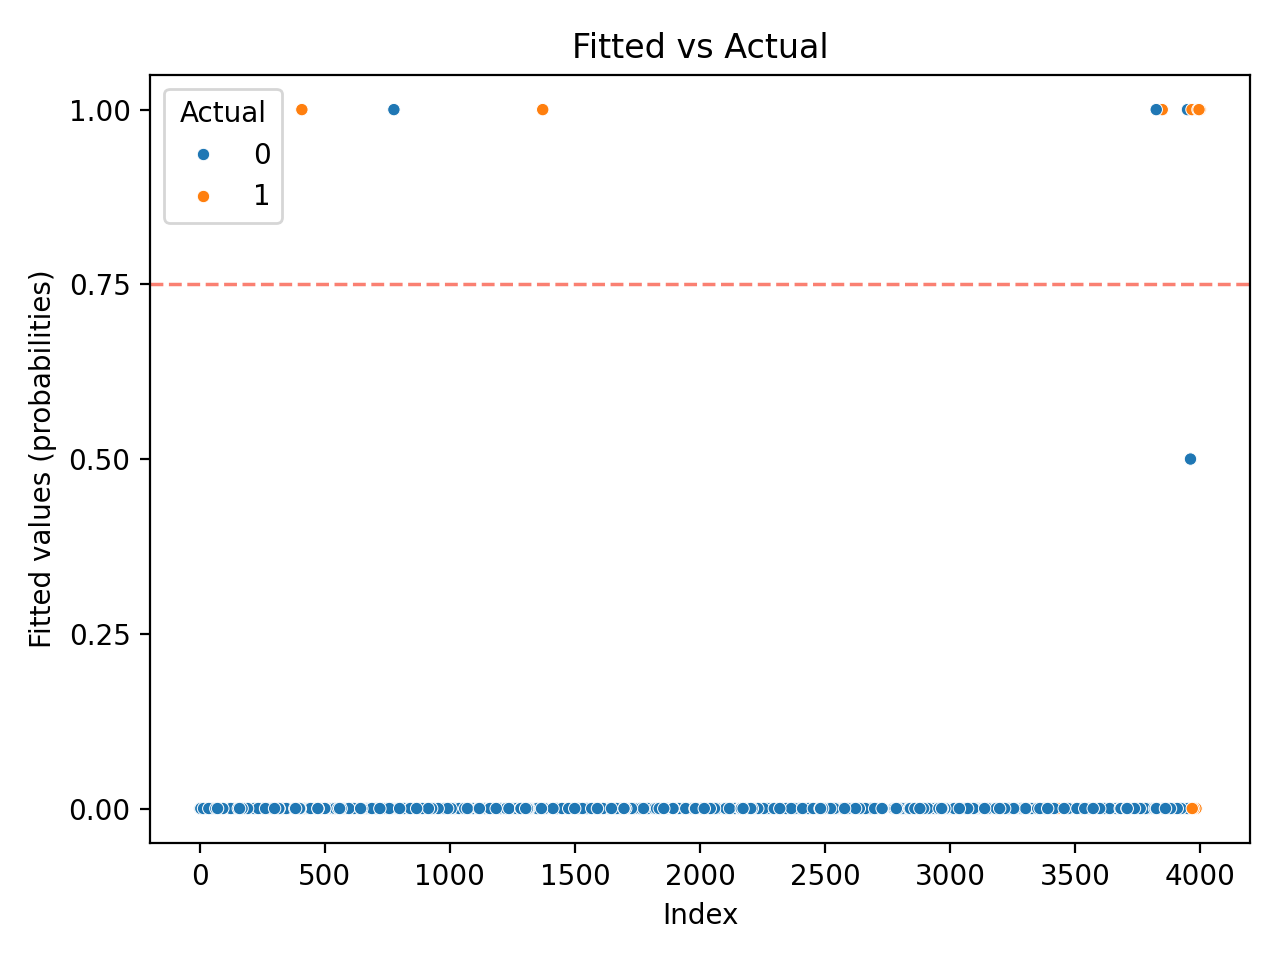

In [64]:
# actual vs. fitted probabilities data
pred_df = pd.DataFrame({"Actual": y_test, "Probs": y_pred_prob})
# actual vs. fitted probabilities graph for test data
sns.scatterplot(data=pred_df, x=pred_df.index, y="Probs", hue="Actual", s=20)
plt.axhline(.75, ls="--", color="salmon", lw=1.25)
plt.xlabel("Index")
plt.ylabel("Fitted values (probabilities)")
plt.title("Fitted vs Actual")
plt.yticks([0,.25,.5,.75,1])
plt.tight_layout()

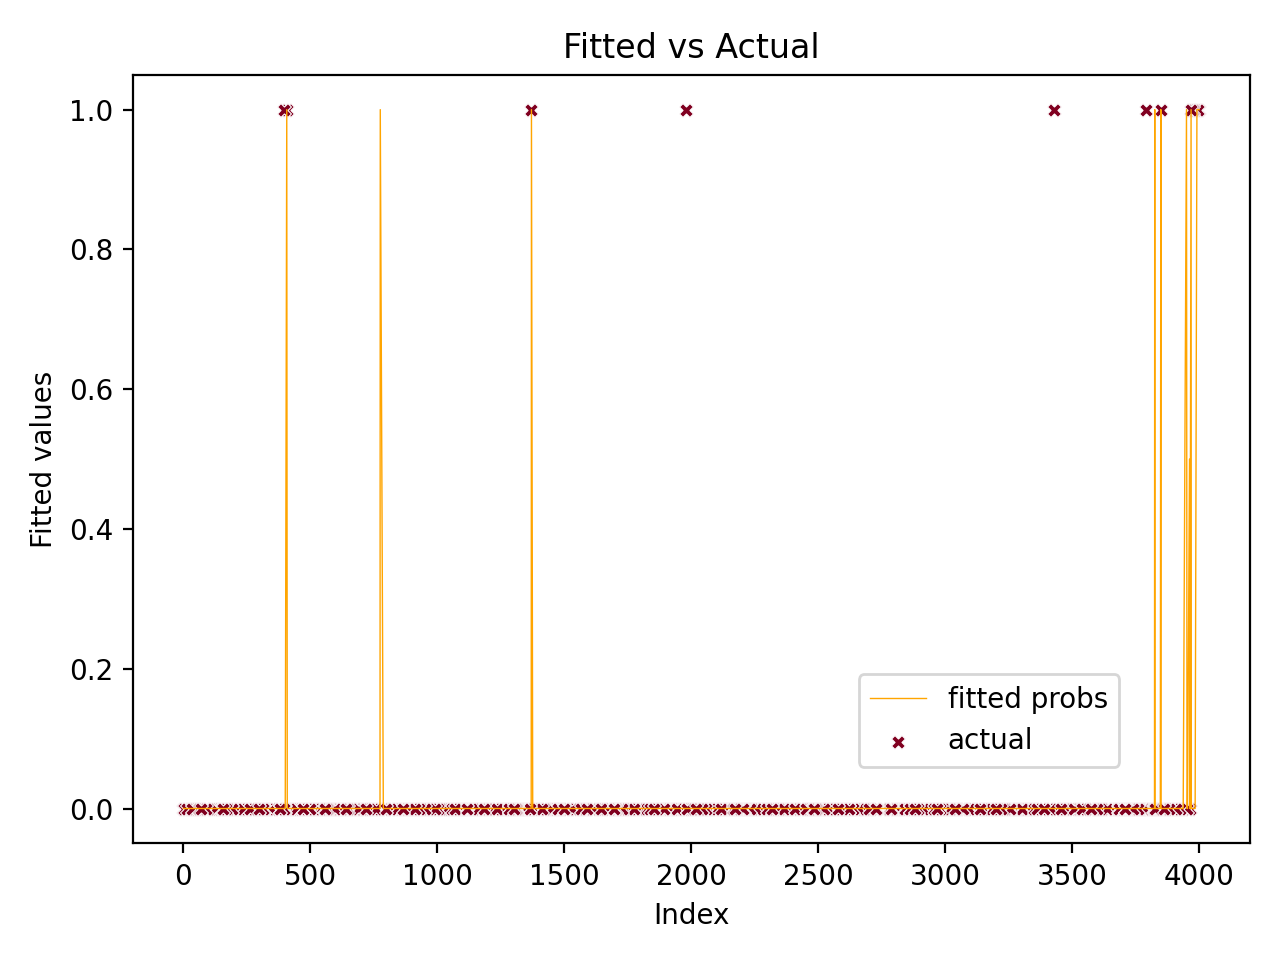

In [65]:
# actual vs. fitted probabilities graph for test data
sns.lineplot(data=pred_df, x=pred_df.index, y="Probs", color="orange", linewidth=.5, label="fitted probs")
sns.scatterplot(data=pred_df, x=pred_df.index, y="Actual", s=25, color="#800020", marker="X",label="actual")
plt.legend(loc=(.65,.1))
plt.xlabel("Index")
plt.ylabel("Fitted values")
plt.title("Fitted vs Actual")
plt.tight_layout()

### b.

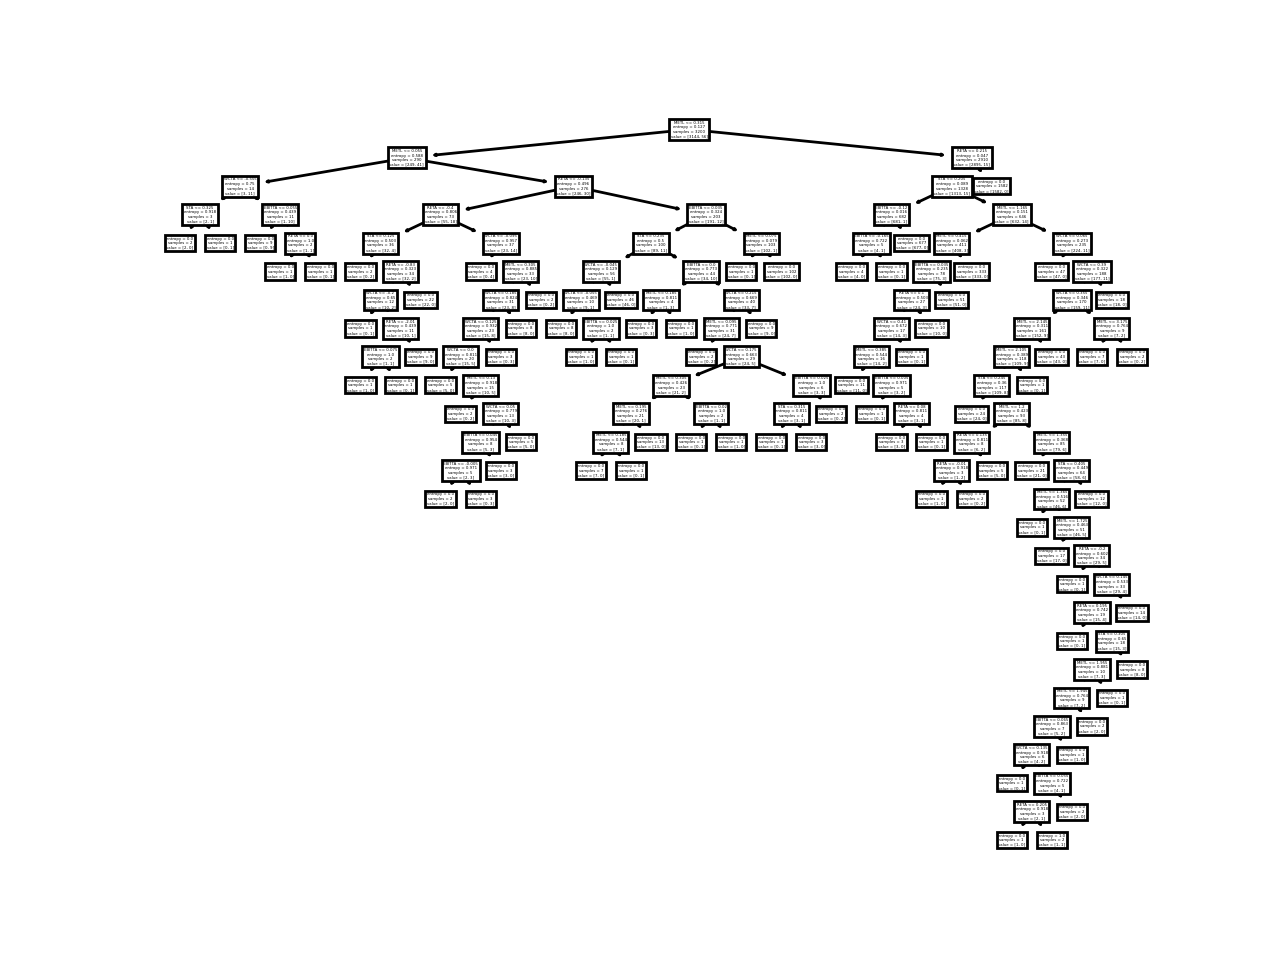

In [66]:
plot_tree(dtree, feature_names=X.columns)
plt.show()

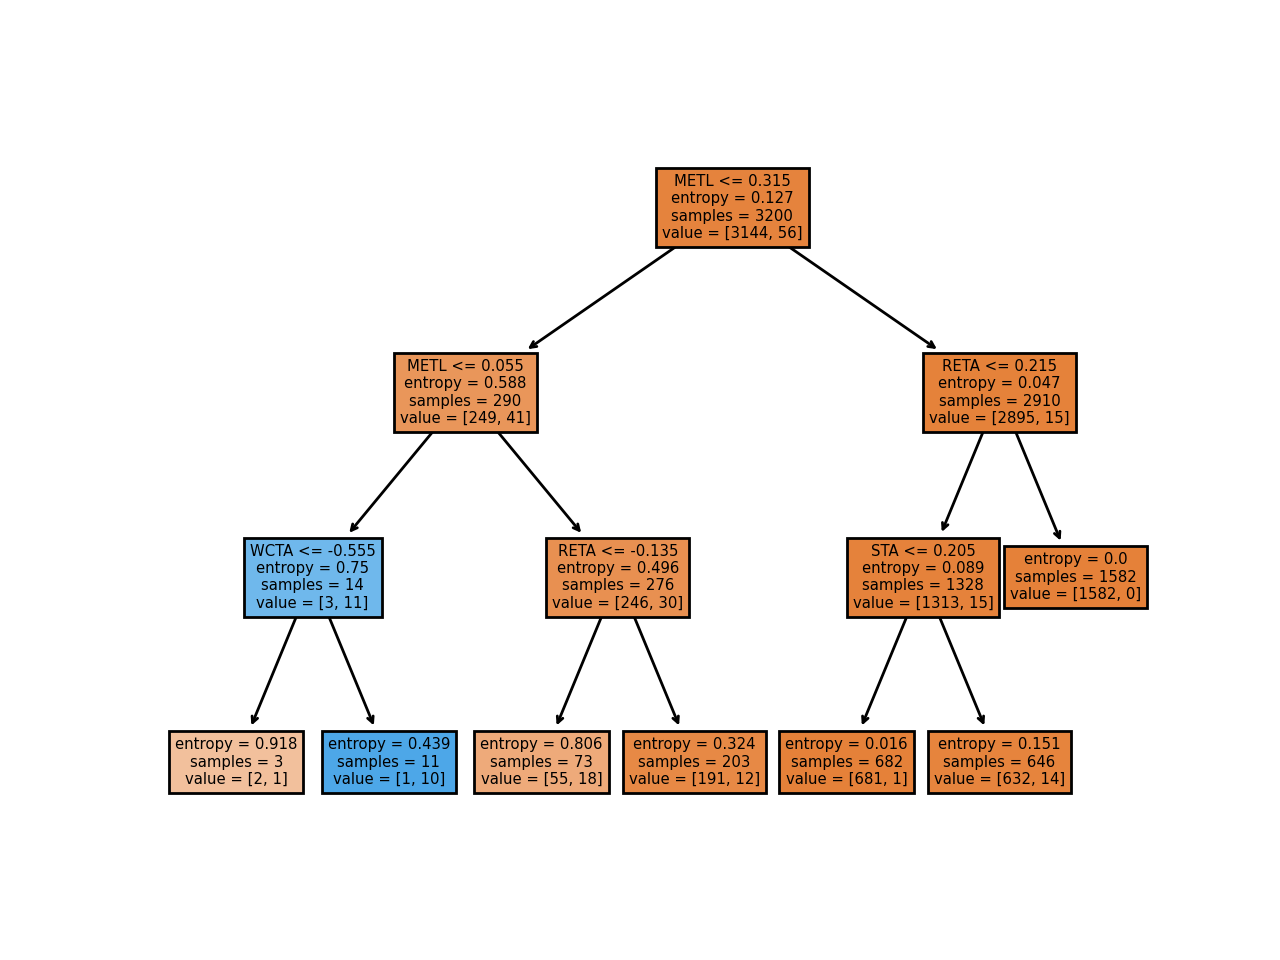

In [67]:
# The graph above is unreadable and there is a huge potential to overfit so I create an alternative tree
# This time I set maximum tree depth as 3 for more readable tree plot
# However, I will go on with both dtree and alt. tree for the next sections
alt_tree = DecisionTreeClassifier(criterion="entropy", max_depth=3, random_state=666).fit(X_train, y_train)
alt_prob = alt_tree.predict_proba(X_test)[:,1]
alt_pred = [0 if p < 0.75 else 1 for p in alt_prob]
plot_tree(alt_tree, feature_names=X.columns, filled=True)
plt.show()

### c.

Accuracy of the model: 0.98625


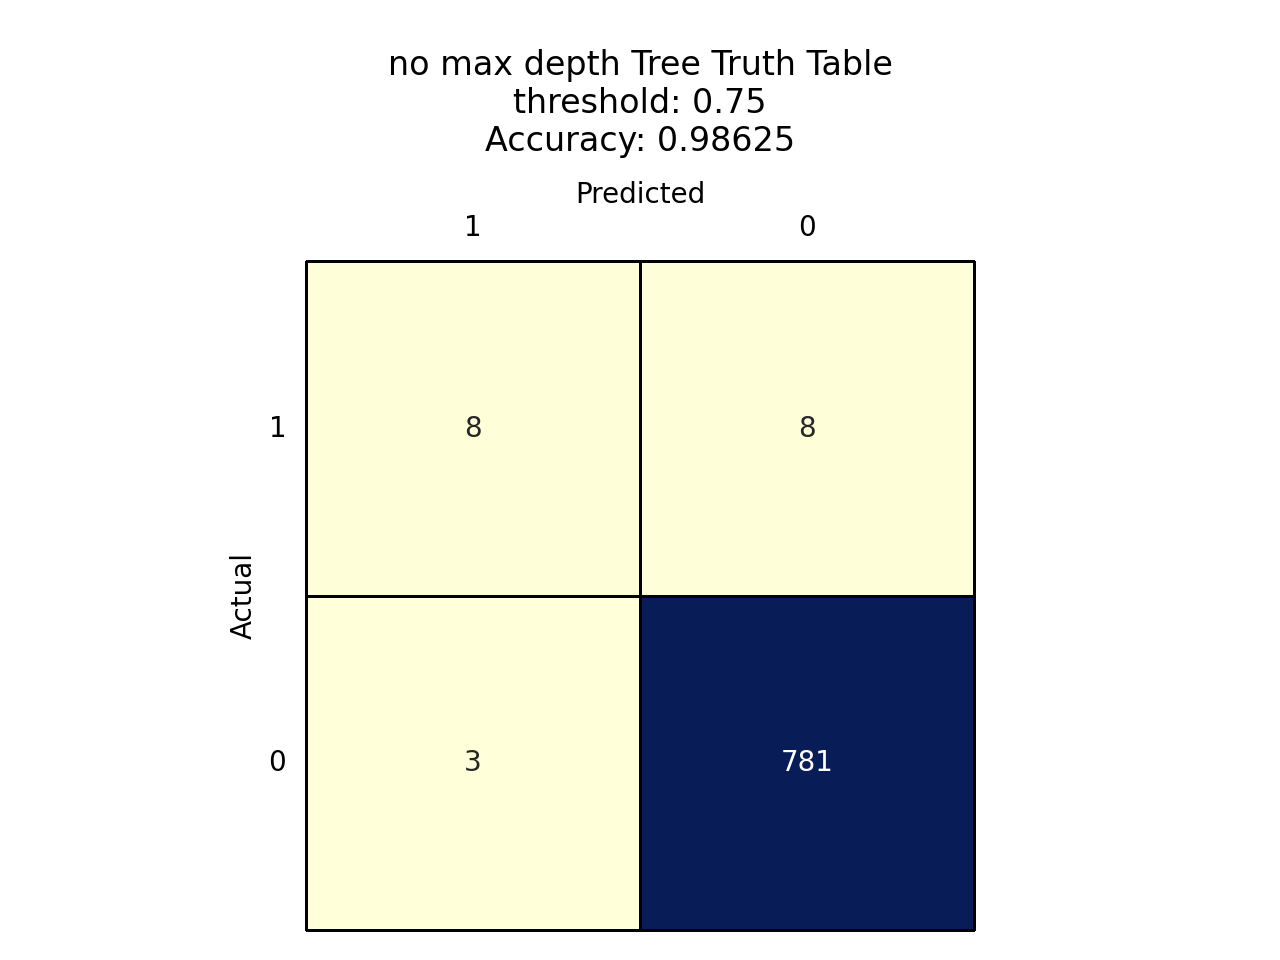

In [68]:
my_truth_table(y_test, y_pred, "no max depth Tree Truth Table\nthreshold: 0.75", decimals=5)
print("Accuracy of the model:",metrics.accuracy_score(y_test, y_pred))

Accuracy of the model: 0.9875


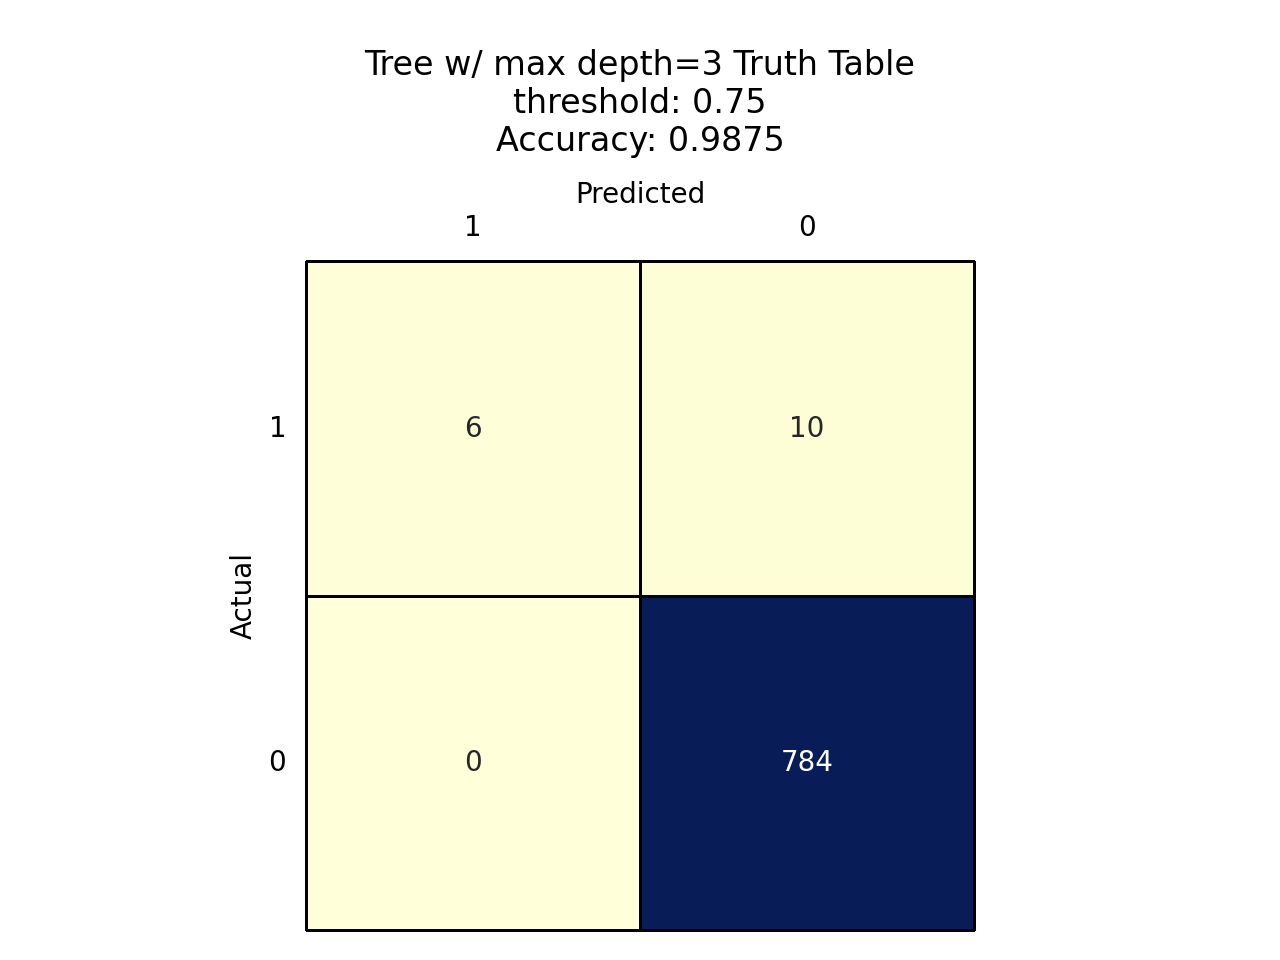

In [69]:
my_truth_table(y_test, alt_pred, "Tree w/ max depth=3 Truth Table\nthreshold: 0.75", decimals=5)
print("Accuracy of the model:",metrics.accuracy_score(y_test, alt_pred))

### d.

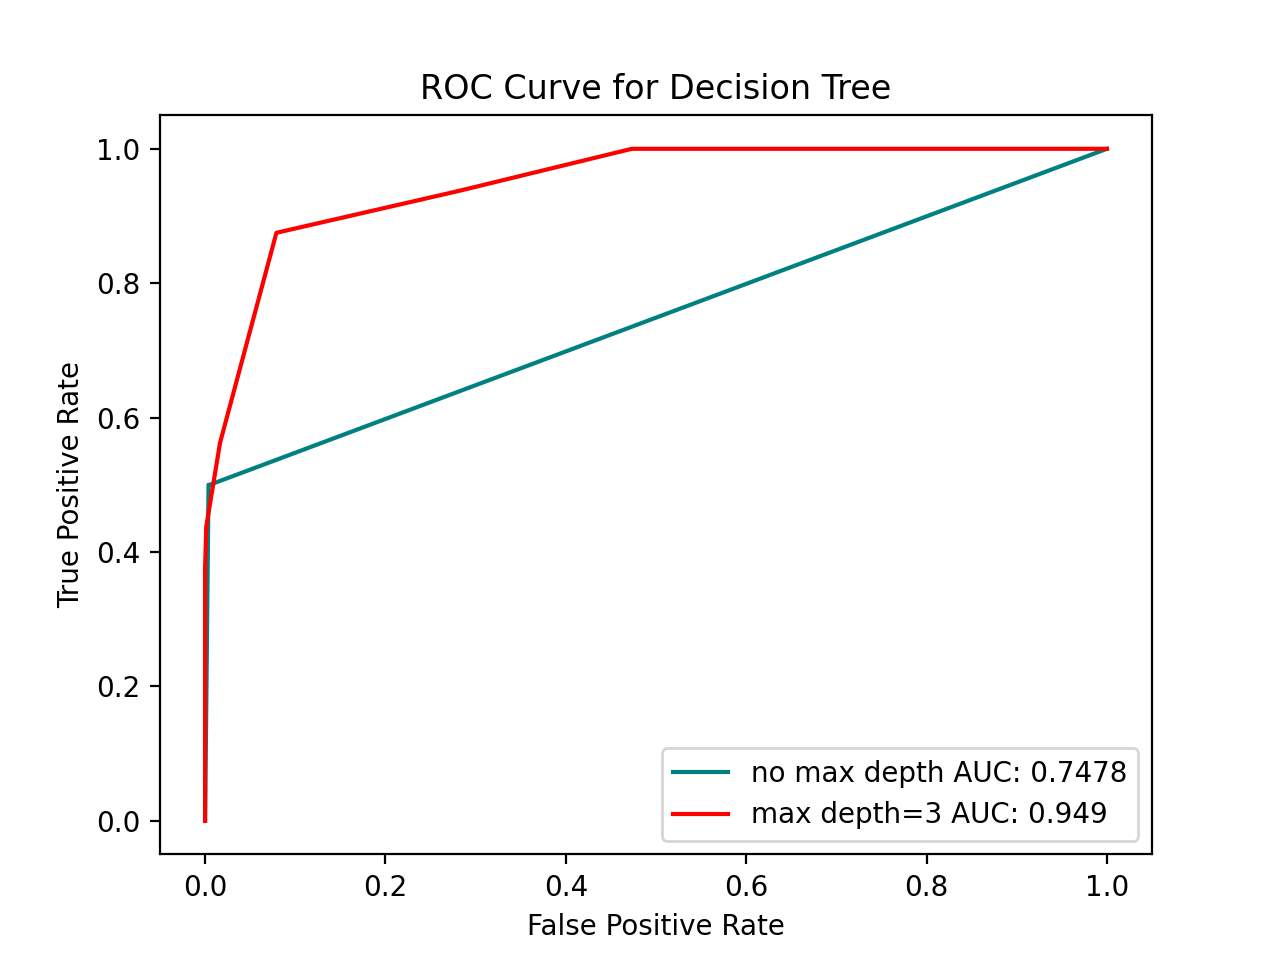

In [70]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_prob)
fpr_alt, tpr_alt, _ = metrics.roc_curve(y_test, alt_prob)
auc_tree = metrics.roc_auc_score(y_test, y_pred_prob)
auc_alt = metrics.roc_auc_score(y_test, alt_prob)
plt.plot(fpr,tpr,label=f"no max depth AUC: {round(auc_tree,4)}", color="teal")
plt.plot(fpr_alt,tpr_alt,label=f"max depth=3 AUC: {round(auc_alt,4)}", color="red")
plt.legend(loc=4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Decision Tree")
plt.show()

So, it seems that setting max depth = 3 significantly improves the decision tree model.